In [1]:
from sklearn import datasets
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Data

In [27]:
iris = datasets.load_iris()
X = iris.data
X = (X-X.mean(axis=0))/X.std(axis=0)
np.corrcoef(X.T)

array([[ 1.        , -0.11756978,  0.87175378,  0.81794113],
       [-0.11756978,  1.        , -0.4284401 , -0.36612593],
       [ 0.87175378, -0.4284401 ,  1.        ,  0.96286543],
       [ 0.81794113, -0.36612593,  0.96286543,  1.        ]])

In [28]:
x, y = X[:,2].reshape(-1,1), X[:,3].reshape(-1,1)

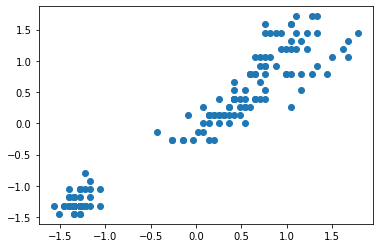

In [29]:
plt.scatter(x,y)
plt.show()

# GP

In [83]:
def squared_exponential_kernel(a, b, sigma=1, l=1):
    sqdist = np.sum(a**2, 1).reshape(-1,1) + np.sum(b**2, 1) - 2*np.dot(a,b.T)
    cov = sigma**2 * np.exp(-0.5 * sqdist / l**2)
    return cov

In [84]:
data = np.linspace(-5,5,100).reshape(-1,1)
K = squared_exponential_kernel(data, data)
K_star = squared_exponential_kernel(data, x)
K_star_star = squared_exponential_kernel(x, x)

In [98]:
print("K.shape", K.shape)
print("K_star.T.shape", K_star.T.shape)
print("K_star_star.shape", K_star_star.shape)

K.shape (150, 150)
K_star.T.shape (150, 100)
K_star_star.shape (150, 150)


In [100]:
CK = np.dot(np.linalg.inv(K), K_star.T)
mu_new = np.dot(y, CK)
K_new = K_star_star - np.dot(CK, K_star)

ValueError: shapes (150,1) and (150,100) not aligned: 1 (dim 1) != 150 (dim 0)

In [96]:
CK.shape

(150, 100)

In [94]:
N = len(x)
sample_draw = 10
K = squared_exponential_kernel(np.sort(x,axis=0), np.sort(x,axis=0)) + 1E-6*np.eye(N)
f_prior = np.random.multivariate_normal(mean=mu_new.reshape(-1), cov=K_new, size=sample_draw).T
plt.plot(np.sort(x,axis=0), f_prior);

ValueError: mean and cov must have same length

In [101]:
mu_new.reshape(-1).shape

(100,)